# Chrometric analysis of the dataset 2

---

## 0. Environmental setup

In [105]:
import sys

sys.path.append("..")

import pandas as pd
import numpy as np
from collections import Counter
import os
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from umap import UMAP
from hdbscan import HDBSCAN
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import fdrcorrection
import math

from src.utils.data_processing import clean_data, remove_correlated_features

from src.utils.data_processing import clean_data, remove_correlated_features
from src.utils.data_viz import plot_feature_space
from src.utils.discrimination import find_markers

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [106]:
def run_correlation_screen(data, label_col):
    results = {
        "feature": [],
        "pearsonr": [],
        "pearsonp": [],
        "pearsonp_adj": [],
        "spearmanr": [],
        "spearmanp": [],
        "spearmanp_adj": [],
    }
    columns = set(data.columns) - {label_col}
    y = np.array(data.loc[:, label_col])
    for col in columns:
        x = np.array(data.loc[:, col])
        pr, pp = pearsonr(x, y)
        if not math.isnan(pp):
            results["feature"].append(col)
            results["pearsonr"].append(pr)
            results["pearsonp"].append(pp)

            sr, sp = spearmanr(x, y)
            results["spearmanr"].append(sr)
            results["spearmanp"].append(sp)
    results["pearsonp_adj"] = fdrcorrection(results["pearsonp"])[1]
    results["spearmanp_adj"] = fdrcorrection(results["spearmanp"])[1]
    return pd.DataFrame(results)

<IPython.core.display.Javascript object>

---

## 1. Read in data

In [2]:
root_dir = "data/dataset2/images/consolidated_features"
nuc_features = pd.read_csv(os.path.join(root_dir, "nuc_features.csv"), index_col =0)
spatial_coords = pd.read_csv(os.path.join(root_dir, "spatial_coordiates.csv"), index_col=0)
nuc_features.head()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,moments_central-3-3,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,image,nuc_id
0,1,38.0,49.0,0.775510,15.622626,26.617404,20.237664,20.029786,15.622626,17.421532,...,-7.421868e+08,0.170206,0.001789,0.000633,1.456844e-05,1.236669e-09,4.840061e-07,6.535727e-10,Composite DLBCL - 001,Composite DLBCL - 001_1
1,2,54.0,89.0,0.606742,24.580086,48.886338,33.647451,34.246165,24.580086,28.986862,...,-3.173075e+10,0.181028,0.006417,0.000261,2.714211e-05,2.273989e-09,2.173962e-06,-2.011614e-10,Composite DLBCL - 001,Composite DLBCL - 001_2
2,3,71.0,107.0,0.663551,30.955170,56.443155,45.225479,44.011482,30.955170,38.734751,...,-8.011972e+11,0.173351,0.003131,0.000187,8.187018e-06,-2.596249e-10,-3.908685e-07,-1.871194e-10,Composite DLBCL - 001,Composite DLBCL - 001_3
3,4,63.0,70.0,0.900000,28.168770,36.280310,32.117238,32.232702,28.168770,31.126964,...,-1.342501e+10,0.160994,0.000149,0.000132,3.907814e-07,-4.926623e-13,-6.196298e-10,-2.768201e-12,Composite DLBCL - 001,Composite DLBCL - 001_4
4,5,46.0,56.0,0.821429,20.904613,28.679452,24.657342,24.606879,20.904613,23.443352,...,-1.839987e+09,0.161983,0.000532,0.000035,6.850657e-07,9.750960e-14,-3.106200e-09,3.372227e-12,Composite DLBCL - 001,Composite DLBCL - 001_5


In [67]:
roi_metadata= pd.read_csv("data/dataset2/DLBCL_ROIs_DZ_ranking.csv", index_col=0)
roi_metadata.head()

,ROILabel,DZ_total_expr
SlideName,,
Composite DLBCL - 006,6,8230.12
Composite DLBCL - 004,4,8077.16
DLBCL Repeat - 011,11,7957.10
Composite DLBCL - 003,3,7936.55
Composite DLBCL - 002,2,7722.37


---

## 2. Data preprocessing

Before we start our analysis, we will briefly save some meta information which are later removed from the dataframe for the purposes of analysis.

In [3]:
images = np.array(nuc_features.image)
nuc_ids = np.array(nuc_features.nuc_id)
labels = np.array(nuc_features.label)
nuc_features.index = nuc_ids

We now remove a number of meta-features and remove samples with missing entries in the feature matrix as well as constant features.

In [4]:
meta_columns = [
    "label",
    "weighted_centroid-0",
    "weighted_centroid-1",
    "centroid-0",
    "centroid-1",
    "bbox-0",
    "bbox-1",
    "bbox-2",
    "bbox-3",
    "nuc_id"
    "image",
    "orientation",
]

In [5]:
cleaned_nuc_feat = clean_data(nuc_features, drop_columns=meta_columns, index_col="nuc_id")

Removed 19 constant or features with missing values. Remaining: 183.
Removed additional 6 features. Remaining: 177.
Removed 0 samples with missing values. Remaining: 24661.


We note that 25 features are removed but no sample was filtered out. The total size of the dataset is 24,661 nuclei. Importantly we have not filtered out nuclei at the boundary of the ROI for now.

We now remove highly correlated features by setting a threshold on the Pearson correlation of 0.8.

In [6]:
filtered_nuc_feat = remove_correlated_features(cleaned_nuc_feat, 0.8)

Removed 112/177 features with a Pearson correlation above 0.8. Remaining: 65


This step removes 112/177 features which means that the processed data matrix consists of 24,661 nuclei described by 65 chrometric features.

## 3. Data visualization

To get a better understanding of the data set and potential batch effects, we will now plot a UMAP representation of the data set.

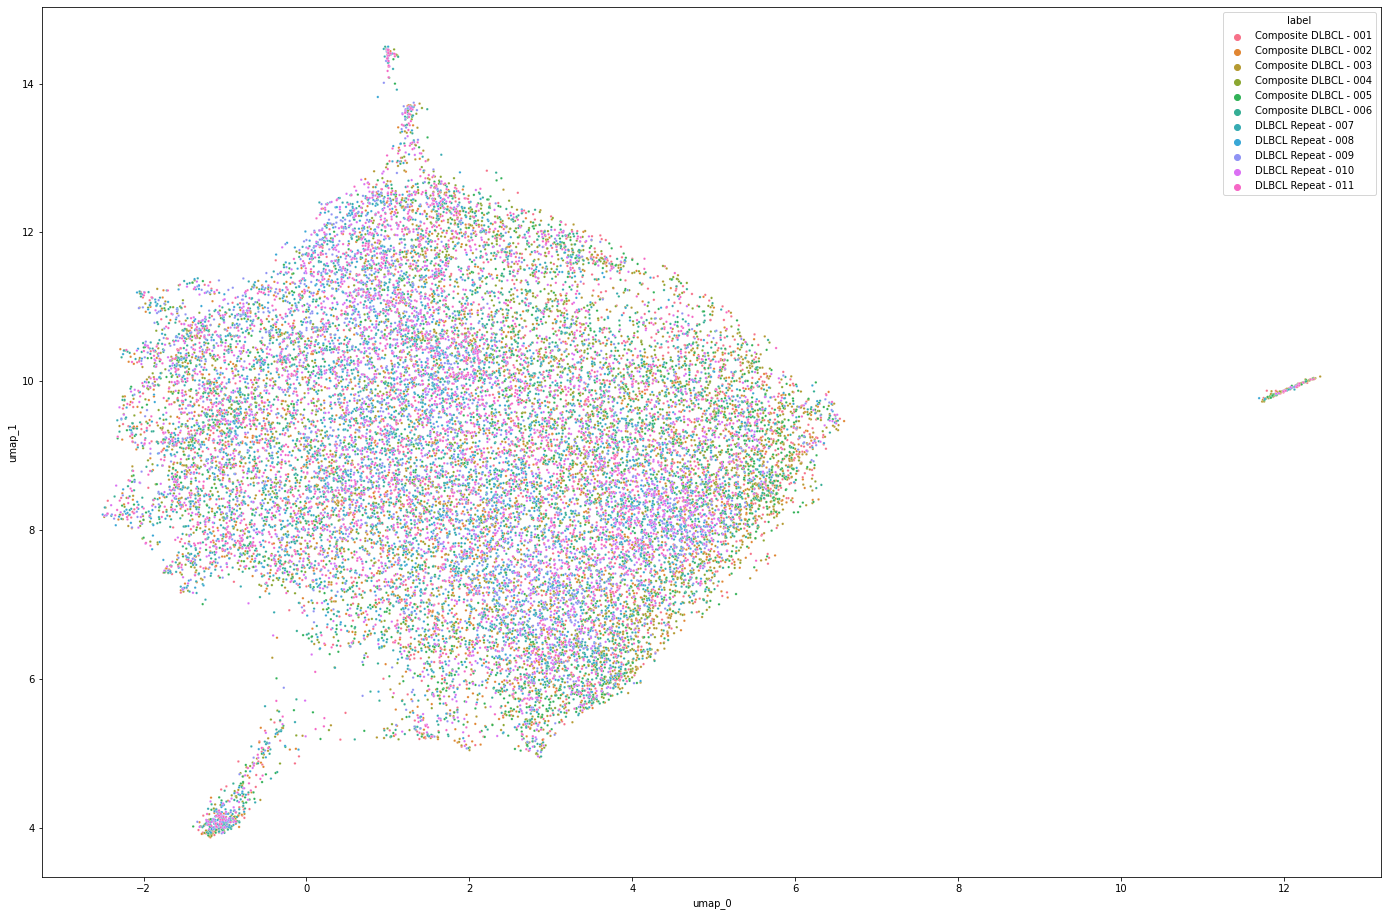

In [7]:
umap_embs = plot_feature_space(filtered_nuc_feat, labels=images, mode="umap", figsize=[24,16], alpha=1, s=6)

The above plot shows the representation of the data set each nuclei represented by a single point colored by the individual ROI images. We observe 4 distinct clusters that however seem to be populated by nuclei from various ROI. Thus, we do not see any strong batch effects.
Nonetheless, we will cluster the UMAP space to identify what those clusters are. To this end, we use a HDBScan algorithm.

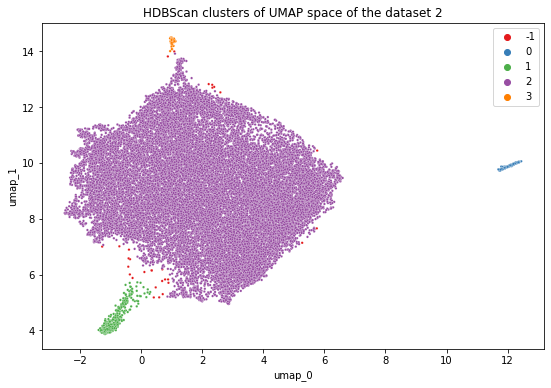

In [19]:
umap_num_embs = np.array(umap_embs.iloc[:, :-1])
cluster_labels = HDBSCAN(min_samples=10, min_cluster_size=50).fit_predict(umap_num_embs)
clustered = (cluster_labels >= 0)
fig, ax = plt.subplots(figsize=[9,6])
ax = sns.scatterplot(data=umap_embs, x="umap_0", y="umap_1", hue=cluster_labels, palette="Set1", s=6)
ax.set_title("HDBScan clusters of UMAP space of the dataset 2")
plt.show()

We see that the cluster identified nicely matches what we would visually expect to be the four different clusters. We thus, will now in particular aim to characterize the clusters 0, 1 and 3 to understand what those represent.

In [45]:
cluster_markers = find_markers(filtered_nuc_feat, cluster_labels)

Run marker screen: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.45it/s]


#### Cluster 0

In [46]:
cluster_markers.loc[(cluster_markers.label == 0) & (cluster_markers.fwer_padj < 1e-5)].sort_values("abs_delta_fc", ascending=False).head(10)

,label,marker,fc,abs_delta_fc,pval,fwer_padj
14,0,skewness,9.908982,8.908982,1.281054e-85,4.163427e-83
19,0,contrast_1,2.517361,1.517361,2.401751e-59,7.805690e-57
18,0,hc_area_ec_area,0.003283,0.996717,0.000000e+00,0.000000e+00
47,0,weighted_moments_hu-3,0.012509,0.987491,2.245725e-39,7.298605e-37
12,0,int_d25,1.972113,0.972113,2.380658e-142,7.737138e-140
46,0,weighted_moments_hu-2,0.032109,0.967891,2.495219e-161,8.109462e-159
45,0,weighted_moments_hu-1,0.117562,0.882438,5.420251e-264,1.761582e-261
28,0,weighted_moments_normalized-1-3,0.122772,0.877228,2.021356e-08,6.569407e-06
34,0,weighted_moments_normalized-3-1,0.146598,0.853402,3.432302e-10,1.115498e-07
31,0,weighted_moments_normalized-2-2,0.160603,0.839397,0.000000e+00,0.000000e+00


The samples in the cluster 0 seem to be dominated by nuclei with a significantly larger skewness in the distribution and substantially higher contrast values suggesting less smooth texture of the chromatin.
Importantly, we validate that the cluster contains nuclei from all ROI images although most samples come from ROI 1 and ROI 3 where those samples correspond to roughly 2% respectively 3% of all nuclei in the data set.

In [47]:
image_counts = dict(Counter(images))
cluster0_counts = dict(Counter(images[cluster_labels==0]))
for k,v in cluster0_counts.items():
    print(k, np.round(v/image_counts[k], 4))

Composite DLBCL - 001 0.0194
Composite DLBCL - 002 0.0046
Composite DLBCL - 003 0.0311
Composite DLBCL - 004 0.0039
Composite DLBCL - 005 0.0119
Composite DLBCL - 006 0.0018
DLBCL Repeat - 007 0.0032
DLBCL Repeat - 008 0.0017
DLBCL Repeat - 009 0.0013
DLBCL Repeat - 010 0.0017
DLBCL Repeat - 011 0.0043


---

#### Cluster 1

In [48]:
cluster_markers.loc[(cluster_markers.label == 1) & (cluster_markers.fwer_padj < 1e-5)].sort_values("abs_delta_fc", ascending=False).head(10)

,label,marker,fc,abs_delta_fc,pval,fwer_padj
23,1,correlation_20,348.122860,347.122860,2.491231e-56,8.096500e-54
39,1,weighted_moments_central-1-1,8.640920,7.640920,1.025786e-08,3.333805e-06
26,1,weighted_moments_normalized-1-1,5.064073,4.064073,3.564744e-12,1.158542e-09
34,1,weighted_moments_normalized-3-1,4.879824,3.879824,1.853099e-10,6.022572e-08
28,1,weighted_moments_normalized-1-3,4.741768,3.741768,1.232736e-09,4.006392e-07
46,1,weighted_moments_hu-2,0.305825,0.694175,1.085316e-51,3.527276e-49
63,1,moments_hu-2,0.462049,0.537951,5.676322e-54,1.844805e-51
2,1,std_radius,1.403155,0.403155,1.438856e-27,4.676283e-25
9,1,num_prominant_neg_curv,1.352835,0.352835,6.489794e-11,2.109183e-08
7,1,med_posi_curv,0.648584,0.351416,0.000000e+00,0.000000e+00


In [49]:
cluster1_counts = dict(Counter(images[cluster_labels==1]))
for k,v in cluster1_counts.items():
    print(k, np.round(v/image_counts[k], 4))

Composite DLBCL - 001 0.0281
Composite DLBCL - 002 0.0234
Composite DLBCL - 003 0.0211
Composite DLBCL - 004 0.0154
Composite DLBCL - 005 0.0244
Composite DLBCL - 006 0.0226
DLBCL Repeat - 007 0.0236
DLBCL Repeat - 008 0.0194
DLBCL Repeat - 009 0.0148
DLBCL Repeat - 010 0.0178
DLBCL Repeat - 011 0.0134


The second cluster does dominantely consist of nuclei of first set of ROIs. The cluster is enriched for nuclei with more regular texture and enlarged nuclei.

---

#### Cluster 3

In [50]:
cluster_markers.loc[(cluster_markers.label == 3) & (cluster_markers.fwer_padj < 1e-5)].sort_values("abs_delta_fc", ascending=False).head(10)

,label,marker,fc,abs_delta_fc,pval,fwer_padj
23,3,correlation_20,7592.020124,7591.020124,1.015515e-94,3.300424e-92
4,3,avg_curvature,3.322194,2.322194,9.712783e-49,3.156654e-46
13,3,kurtosis,2.510797,1.510797,8.164656e-12,2.653513e-09
39,3,weighted_moments_central-1-1,0.002555,0.997445,1.538920e-24,5.001491e-22
21,3,homogeneity_20,0.094559,0.905441,1.174697e-37,3.817765e-35
31,3,weighted_moments_normalized-2-2,1.903647,0.903647,1.130132e-08,3.672928e-06
9,3,num_prominant_neg_curv,0.130572,0.869428,2.821495e-38,9.169859e-36
2,3,std_radius,0.242367,0.757633,6.332378e-68,2.058023e-65
0,3,min_calliper,0.293425,0.706575,4.229786e-125,1.374680e-122
63,3,moments_hu-2,0.302674,0.697326,3.552694e-23,1.154625e-20


In [52]:
cluster3_counts = dict(Counter(images[cluster_labels==3]))
for k,v in cluster3_counts.items():
    print(k, np.round(v/image_counts[k], 4))

Composite DLBCL - 001 0.0026
Composite DLBCL - 002 0.0005
Composite DLBCL - 003 0.0029
Composite DLBCL - 004 0.003
Composite DLBCL - 005 0.001
Composite DLBCL - 006 0.0009
DLBCL Repeat - 007 0.005
DLBCL Repeat - 008 0.0034
DLBCL Repeat - 009 0.0031
DLBCL Repeat - 010 0.0025
DLBCL Repeat - 011 0.0067


The final cluster which is also the smallest tends to be slightly enriched for nuclei from the final 5 ROIs corresponding to the repeat experiment. It features nuclei with extremely regular texture but very rigid texture which additionally feature more curved shapes.

---

In summary the difference in the class frequencies of the indvidual clusters will inform our downstream analysis when comparing the individual ROIs. In particular, we will run the analysis in two ways: one time using all nuclei and another time only using the nuclei from the largest UMAP cluster thus excluding those special cases.

---

## 3. Comparison of the ROIs

When comparing the individual ROIs we are in particular interested in understanding which features correlate with the measured DZ expression given in the metadata. To identify those, we will first compute the median values for each of the ROIs and compute the Pearson and Spearman correlation coefficient for each feature with the respective expression value.

In [116]:
median_nuc_feat = cleaned_nuc_feat.copy()
median_nuc_feat.loc[:, "image"] = images
median_nuc_feat = median_nuc_feat.groupby("image").median()
median_nuc_feat.head()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,d75_radius,...,moments_central-3-1,moments_central-3-2,moments_central-3-3,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6
image,,,,,,,,,,,,,,,,,,,,,
Composite DLBCL - 001,40.0,61.0,0.672003,16.924421,31.683853,23.962837,24.014632,16.989743,20.387757,27.283539,...,-7.382130e+05,221476.938895,-1.044938e+08,0.175555,0.004034,0.000211,0.000007,1.182721e-11,2.192477e-08,3.280989e-15
Composite DLBCL - 002,40.0,61.0,0.666667,17.249006,32.174013,24.271629,24.541361,17.333910,20.792503,27.533617,...,-9.599423e+05,535115.545823,-1.085182e+08,0.176093,0.004339,0.000198,0.000007,5.698019e-12,1.141933e-08,1.997031e-14
Composite DLBCL - 003,43.0,64.0,0.684211,18.416429,33.303067,25.446872,25.626197,18.448690,22.035277,28.777675,...,-1.391385e+05,220211.348143,-1.184793e+07,0.174032,0.003633,0.000196,0.000006,4.281220e-12,6.542508e-09,-3.106000e-15
Composite DLBCL - 004,36.0,55.0,0.682733,15.327099,29.055210,21.600542,21.747084,15.388484,18.629023,24.700593,...,-3.846388e+05,-56248.491585,-4.064168e+07,0.174469,0.003649,0.000214,0.000007,8.597248e-12,1.576975e-08,-7.067050e-15
Composite DLBCL - 005,42.0,63.0,0.681159,18.109223,32.842413,25.515351,25.456952,18.143700,21.901440,28.469900,...,-1.224896e+06,224357.445261,-1.568622e+08,0.174440,0.003796,0.000198,0.000006,6.630420e-12,1.246970e-08,7.791257e-17


<IPython.core.display.Javascript object>

We decided to use the median to be more robust to outliers in the data set.

In [117]:
median_nuc_feat.loc[:, "dz_expr"] = np.array(
    roi_metadata.loc[median_nuc_feat.index, "DZ_total_expr"]
)

<IPython.core.display.Javascript object>

In [118]:
cor_screen_results = run_correlation_screen(median_nuc_feat, "dz_expr")
cor_screen_results.sort_values("pearsonp_adj").head(10)

/usr/share/miniconda3/envs/gc/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,feature,pearsonr,pearsonp,pearsonp_adj,spearmanr,spearmanp,spearmanp_adj
26,hc_area_ec_area,0.884320,0.000301,0.033639,0.927273,0.000040,0.006914
131,hc_area_nuc_area,0.877418,0.000387,0.033639,0.909091,0.000106,0.009187
165,nhigh_nlow,-0.752176,0.007575,0.439372,-0.706152,0.015154,0.461474
0,max_posi_curv,0.355892,0.282737,0.725521,0.453836,0.160881,0.603111
83,med_radius,-0.467184,0.147387,0.725521,-0.390909,0.234540,0.603111
82,skewness,0.691582,0.018404,0.725521,0.500000,0.117307,0.603111
81,max_calliper,-0.492227,0.124039,0.725521,-0.442439,0.172989,0.603111
80,frac_peri_w_posi_curvature,0.358750,0.278611,0.725521,0.436364,0.179665,0.603111
159,perimeter,-0.441810,0.173672,0.725521,-0.381818,0.246560,0.603111
75,moments-0-2,-0.395708,0.228335,0.725521,-0.345455,0.298089,0.603111


<IPython.core.display.Javascript object>

In [120]:
cor_screen_results.loc[cor_screen_results.feature.isin(["i80_i20", "homogeneity_1"])]

,feature,pearsonr,pearsonp,pearsonp_adj,spearmanr,spearmanp,spearmanp_adj
62,i80_i20,-0.123542,0.717431,0.924689,-0.136364,0.689309,0.888443
73,homogeneity_1,-0.437057,0.178895,0.725521,-0.354545,0.284693,0.603111


<IPython.core.display.Javascript object>

We see that the only feature that significantly (FDR < 0.05) correlated with the measured DZ expression is the HC/EC ratio. Interestingly, that feature was not among the most discriminative features for distinguishing light zone B cells from dark zone B cells. This can be explained by the fact that the applied quantile normalization to deal with the different brightness levels of the individual nuclei yields similar intensity distributions within the ROIs thus comparing the median I80_I20 (that is the ratio of the 80%tile and 20%tile) will be very similar for each ROI thus not correlated with the different expression levels.

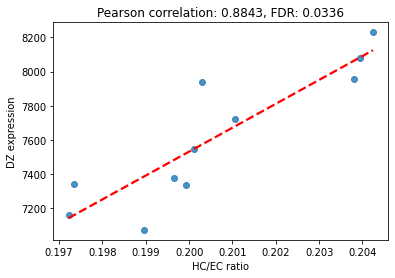

<IPython.core.display.Javascript object>

In [138]:
pr_pp_adj = np.array(
    cor_screen_results.loc[
        cor_screen_results.feature == "hc_area_ec_area", ["pearsonr", "pearsonp_adj"]
    ]
).flatten()
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.regplot(
    data=median_nuc_feat,
    x="hc_area_ec_area",
    y="dz_expr",
    ax=ax,
    x_ci=None,
    ci=None,
    line_kws={"color": "r", "linestyle": "--"},
)
ax.set_title(
    "Pearson correlation: {}, FDR: {}".format(
        np.round(pr_pp_adj[0], 4), np.round(pr_pp_adj[1], 4)
    )
)
ax.set_ylabel("DZ expression")
ax.set_xlabel("HC/EC ratio")
plt.show()

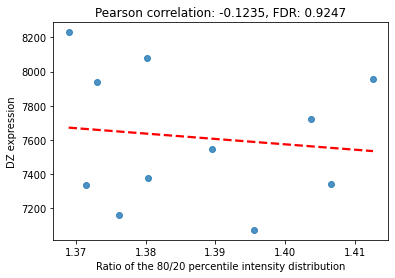

<IPython.core.display.Javascript object>

In [140]:
pr_pp_adj = np.array(
    cor_screen_results.loc[
        cor_screen_results.feature == "i80_i20", ["pearsonr", "pearsonp_adj"]
    ]
).flatten()
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.regplot(
    data=median_nuc_feat,
    x="i80_i20",
    y="dz_expr",
    ax=ax,
    x_ci=None,
    ci=None,
    line_kws={"color": "r", "linestyle": "--"},
)
ax.set_title(
    "Pearson correlation: {}, FDR: {}".format(
        np.round(pr_pp_adj[0], 4), np.round(pr_pp_adj[1], 4)
    )
)
ax.set_ylabel("DZ expression")
ax.set_xlabel("Ratio of the 80/20 percentile intensity distribution")
plt.show()

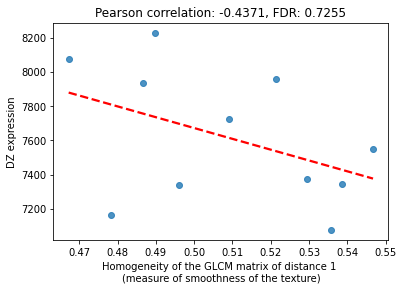

<IPython.core.display.Javascript object>

In [142]:
pr_pp_adj = np.array(
    cor_screen_results.loc[
        cor_screen_results.feature == "homogeneity_1", ["pearsonr", "pearsonp_adj"]
    ]
).flatten()
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.regplot(
    data=median_nuc_feat,
    x="homogeneity_1",
    y="dz_expr",
    ax=ax,
    x_ci=None,
    ci=None,
    line_kws={"color": "r", "linestyle": "--"},
)
ax.set_title(
    "Pearson correlation: {}, FDR: {}".format(
        np.round(pr_pp_adj[0], 4), np.round(pr_pp_adj[1], 4)
    )
)
ax.set_ylabel("DZ expression")
ax.set_xlabel(
    "Homogeneity of the GLCM matrix of distance 1 \n(measure of smoothness of the texture)"
)
plt.show()